In [2]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os
import matplotlib.pyplot as plt
import glob

In [3]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import warnings

In [4]:
n_cpu = 8

In [5]:
# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 100 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0005 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 10 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

In [8]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [9]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [10]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [12]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [13]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [14]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [15]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [16]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [17]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

In [18]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [19]:

root = '/home/msst/Documents/datasets/Anime'
print(os.listdir(root))

['trainB', 'trainA']


In [20]:
list_names = os.listdir('/home/msst/Documents/datasets/OnOff/trainA')

In [21]:
# import time
# for img_name in list_names:
#     time.sleep(2)
#     clear_output()
#     print(img_name)
#     img = Image.open('/home/msst/Documents/datasets/OnOff/trainA/' + img_name)
#     plt.imshow(img)
#     plt.show()

In [22]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/trainA')+'/*.*'))
            self.files_B = sorted(glob.glob(os.path.join(root+'/trainB')+'/*.*'))
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/testA')+'/*.*'))
            self.files_B = sorted(glob.glob(os.path.join(root+'/testB')+'/*.*'))

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [23]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=3, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),#, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

In [24]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].to('cuda') # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].to('cuda') # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.figure(figsize=(10,10))
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

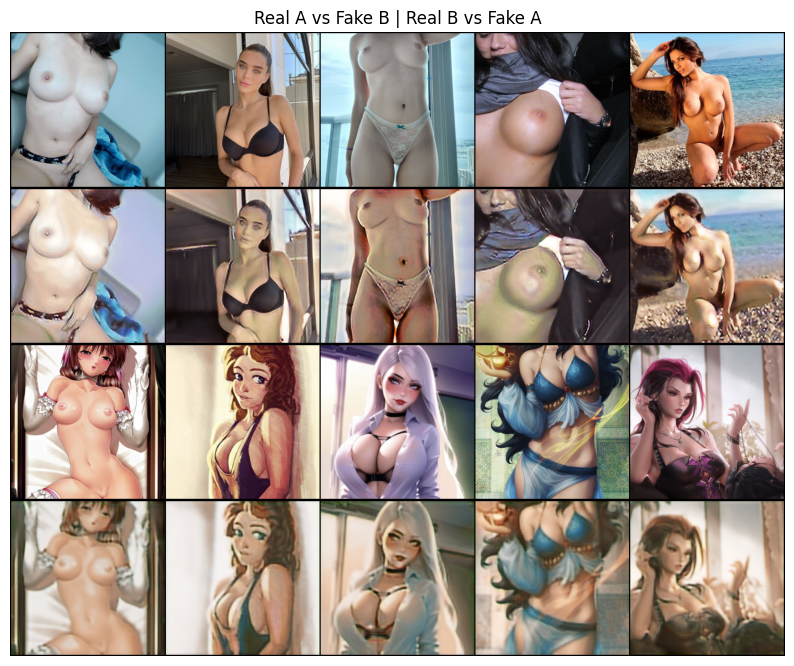

[Epoch 41/100] [Batch 25/71] [D loss : 0.267742] [G loss : 1.399375 - (adv : 0.187594, cycle : 0.130273, identity : 0.112084)]


In [ ]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['A'].to("cuda")
        real_B = batch['B'].to("cuda")
        
        # Adversarial ground truths
        valid = (torch.ones((real_A.size(0), *D_A.output_shape))).to("cuda") # requires_grad = False. Default.
        fake = (torch.zeros((real_A.size(0), *D_A.output_shape))).to("cuda") # requires_grad = False. Default.
        
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
# ------> Total Loss
        loss_G = 1*loss_GAN + (5*loss_cycle) + (5*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
# -----------------
# Show Progress
# -----------------
        if (i+1) % 25 == 0:
            clear_output()
            sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))